<img src="../img/logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales
# Semana 6:
#### Nicolás Pereyra
---

## Consigna:

En esta tarea continuaremos con el capítulo 14 de Holton. *DSP Principles and Applications*.

Comenzaremos con la generación de la siguiente señal:

$x(k) = a_0 \cdot \sin(\Omega_1 \cdot k) + n_a(k)$

siendo:  
- \( $a_0 = 2$ \)  
- \( $\Omega_1 = \Omega_0 + f_r \cdot \frac{2\pi}{N}$ \)  
- \( $\Omega_0 = \frac{\pi}{2}$ \)  

siendo la variable aleatoria definida por la siguiente distribución de probabilidad:  
- \( $f_r \sim U(-2, 2)$ \)  
- \( $n_a \sim \mathcal{N}(0, \sigma^2)$ \)  

Diseñe los siguientes estimadores de amplitud \( $a_1$ \):

$\hat{a}_1^i = |X_w^i(\Omega_0)| = \left| \mathcal{F}\{x(n) \cdot w_i(n)\} \right|$

y de frecuencia \( $\Omega_1$ \):

$\hat{\Omega}_1^i = \arg\max \left\{ |X_w^i(\Omega)| \right\}$

Para cada una de las siguientes ventanas:
- Rectangular (sin ventana)
- FlatTop  
- Blackman-Harris  
- Otra a elección de `scipy.signal.windows`

---

## Experimentación

Considere 200 realizaciones (muestras tomadas de \( $f_r$ \)) de 1000 muestras para cada experimento.  
Parametrice para SNRs de 3 dB y 10 dB.  
**Ayuda**: calibre \( $a_1$ \) para que la potencia de la senoidal sea 1 W.

---

## Se pide:

1) Realizar una tabla por cada SNR que describa el sesgo y la varianza de cada estimador, para cada ventana analizada.  
   Se debe estimar la varianza en la **amplitud** y en la **frecuencia**.

---

## Ayuda:

Se puede calcular experimentalmente el sesgo y la varianza de un estimador. Para la amplitud:

$\hat{a}_0 = |X_w^i(\Omega_0)|$

Entonces:

- Sesgo:  
  $s_a = \mathbb{E}[\hat{a}_0] - a_0$

- Varianza:  
  $v_a = \text{Var}[\hat{a}_0] = \mathbb{E}[(\hat{a}_0 - \mathbb{E}[\hat{a}_0])^2]$

Y estas se pueden aproximar experimentalmente como:

- Media muestral:  
  $\mu_{\hat{a}} = \frac{1}{M} \sum_{j=0}^{M-1} \hat{a}_j$

- Sesgo:  
  $s_a = \mu_{\hat{a}} - a_0$

- Varianza:  
  $v_a = \frac{1}{M} \sum_{j=0}^{M-1} (\hat{a}_j - \mu_{\hat{a}})^2$

---

### Bonus

💎 Analice el efecto del *zero-padding* sobre el estimador \( $\hat{\Omega}_1$ \)

🤯 Proponga estimadores alternativos para frecuencia y amplitud de la senoidal y repita el experimento.


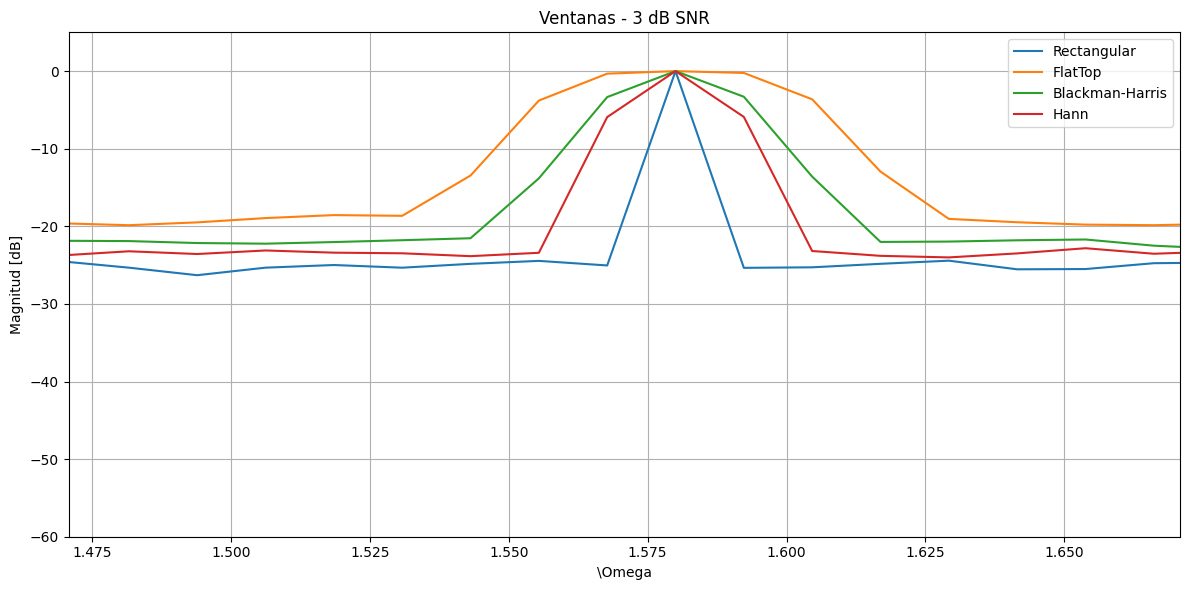


SNR = 3 dB
        Ventana  Bias Amplitud  Var Amplitud  Bias Frecuencia  Var Frecuencia
    Rectangular     362.289150    254.007897        -3.138519         0.00000
        FlatTop      77.026208     46.921152        -2.982976         0.46896
Blackman-Harris     127.353271     64.724664        -3.138519         0.00000
           Hann     180.215143     92.931038        -3.138519         0.00000


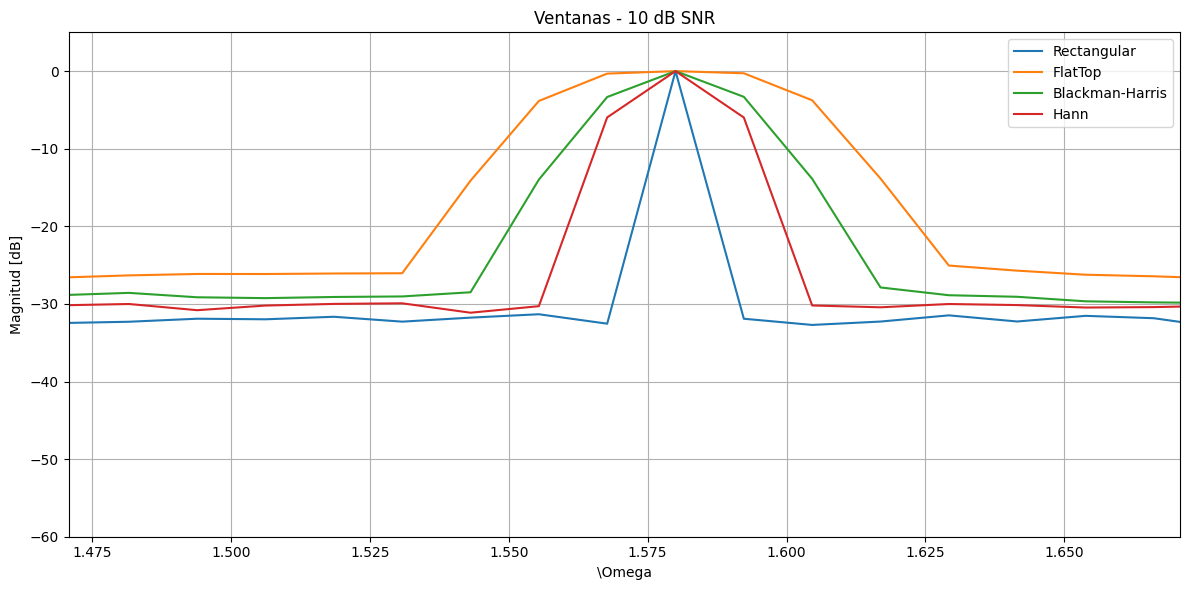


SNR = 10 dB
        Ventana  Bias Amplitud  Var Amplitud  Bias Frecuencia  Var Frecuencia
    Rectangular     807.880575    250.726888        -3.138519        0.000000
        FlatTop     172.019931     57.753549        -3.044209        0.289136
Blackman-Harris     287.260120     68.520512        -3.138519        0.000000
           Hann     401.597857     77.087372        -3.138519        0.000000


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import windows

# Parámetros generales
N = 512
omega_0 = np.pi * 0.5
SNR_dBs = [3, 10]
n_realizaciones = 100

# Ventanas
ventanas = {
    'Rectangular': windows.boxcar(N),
    'FlatTop': windows.flattop(N),
    'Blackman-Harris': windows.blackmanharris(N),
    'Hann': windows.hann(N)
}

# Para guardar datos
datos = {}

for SNR_dB in SNR_dBs:
    ruido_std = 1
    amplitud = ruido_std * 10**(SNR_dB / 20)
    datos[SNR_dB] = {}

    for nombre, ventana in ventanas.items():
        amp_estimadas = []
        freq_estimadas = []
        espectros = []

        for _ in range(n_realizaciones):
            n = np.arange(N)
            senal = amplitud * np.cos(omega_0 * n)
            ruido = np.random.normal(0, ruido_std, N)
            x = (senal + ruido) * ventana

            X = np.fft.fft(x)
            X = np.fft.fftshift(X)
            mag = np.abs(X)
            espectros.append(mag)

            idx_max = np.argmax(mag)
            omega = np.linspace(-np.pi, np.pi, N)
            freq_estimadas.append(omega[idx_max])
            amp_estimadas.append(mag[idx_max])

        amp_estimadas = np.array(amp_estimadas)
        freq_estimadas = np.array(freq_estimadas)

        bias_amp = np.mean(amp_estimadas) - amplitud
        var_amp = np.var(amp_estimadas)

        bias_freq = np.mean(freq_estimadas) - omega_0
        var_freq = np.var(freq_estimadas)

        datos[SNR_dB][nombre] = {
            'bias_amp': bias_amp,
            'var_amp': var_amp,
            'bias_freq': bias_freq,
            'var_freq': var_freq,
            'espectros': espectros
        }

    # ---- Graficar espectros ----
    plt.figure(figsize=(12, 6))
    omega = np.linspace(-np.pi, np.pi, N)
    for nombre in ventanas:
        espectros = np.array(datos[SNR_dB][nombre]['espectros'])
        promedio = np.mean(espectros, axis=0)
        promedio_db = 20 * np.log10(promedio / np.max(promedio))
        plt.plot(omega, promedio_db, label=nombre)

    plt.title(f"Ventanas - {SNR_dB} dB SNR")
    plt.xlabel(r"\Omega")
    plt.ylabel("Magnitud [dB]")
    plt.legend()
    plt.grid(True)
    plt.xlim(omega_0 - 0.1, omega_0 + 0.1)
    plt.ylim(-60, 5)
    plt.tight_layout()
    plt.show()

    # ---- Mostrar tabla ----
    import pandas as pd
    filas = []
    for nombre in ventanas:
        r = datos[SNR_dB][nombre]
        filas.append([nombre, r['bias_amp'], r['var_amp'], r['bias_freq'], r['var_freq']])

    df = pd.DataFrame(filas, columns=['Ventana', 'Bias Amplitud', 'Var Amplitud', 'Bias Frecuencia', 'Var Frecuencia'])
    print(f"\nSNR = {SNR_dB} dB")
    print(df.to_string(index=False))



SNR = 3 dB


,Ventana,Sesgo a,Varianza a,Sesgo Ω,Varianza Ω
0,rectangular,383.609370,101977.335789,-0.004772,0.000050
1,flattop,196.124460,561.836294,-0.004846,0.000055
2,blackmanharris,238.680367,8972.843942,-0.004780,0.000050
3,hann,263.621992,29462.826370,-0.004772,0.000050



SNR = 10 dB


,Ventana,Sesgo a,Varianza a,Sesgo Ω,Varianza Ω
0,rectangular,361.049936,108001.446520,-0.003833,0.000052
1,flattop,195.294200,524.964389,-0.003743,0.000053
2,blackmanharris,234.782072,8782.564756,-0.003825,0.000051
3,hann,255.771007,29092.125122,-0.003833,0.000051


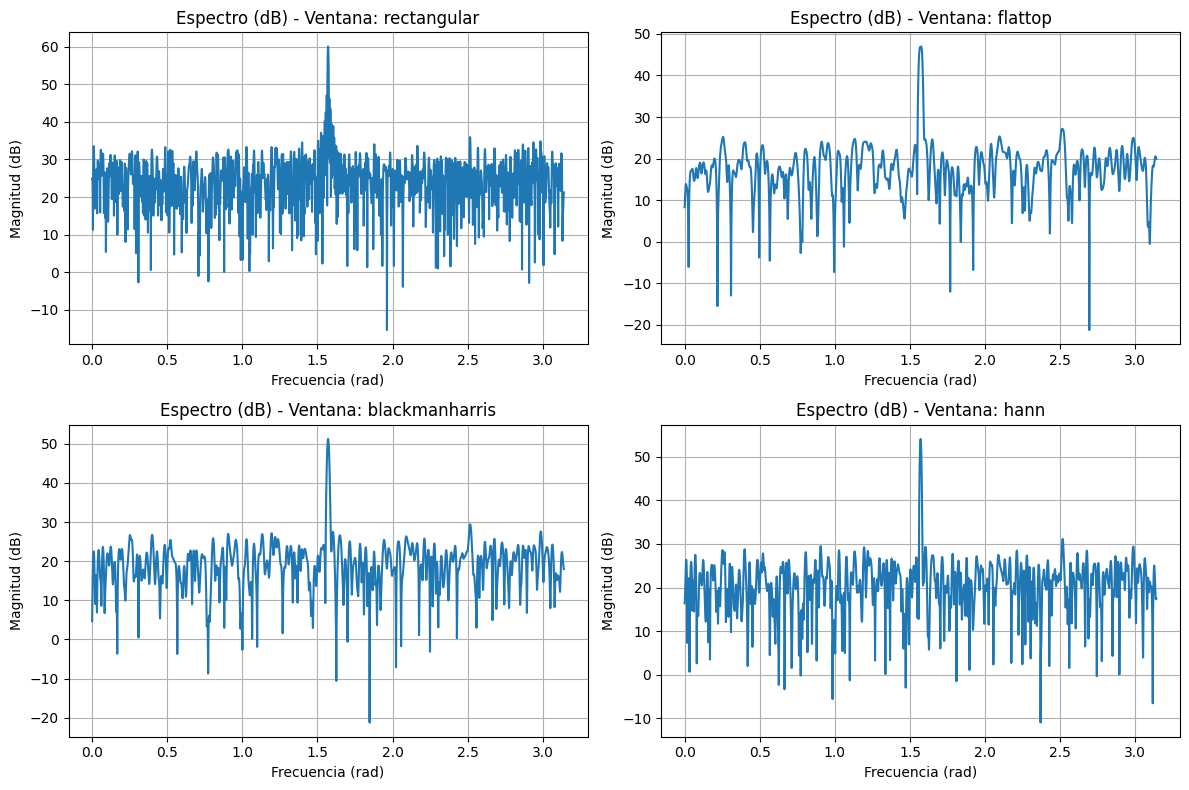

In [11]:
import numpy as np
import scipy.signal.windows as win
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from IPython.display import display

# Parámetros generales
M = 200         # Número de realizaciones
N = 1000        # Muestras por realización
a0 = 2
Omega_0 = np.pi / 2
SNR_dBs = [3, 10]
windows = {
    'rectangular': np.ones(N),
    'flattop': win.flattop(N),
    'blackmanharris': win.blackmanharris(N),
    'hann': win.hann(N)  # Otra ventana elegida
}

# Calibración de ruido para SNR (Potencia senoidal = 1 W)
signal_power = 1
noise_variances = [signal_power / (10**(snr_db / 10)) for snr_db in SNR_dBs]

# Resultados acumuladores
results = {snr: {w: {'amp_est': [], 'freq_est': []} for w in windows} for snr in SNR_dBs}
last_Omega_1 = None  # Para guardar la última frecuencia para referencia

for snr_db, var in zip(SNR_dBs, noise_variances):
    for _ in range(M):
        fr = np.random.uniform(-2, 2)
        Omega_1 = Omega_0 + fr * (2 * np.pi / N)
        last_Omega_1 = Omega_1
        k = np.arange(N)
        x = a0 * np.sin(Omega_1 * k)
        noise = np.random.normal(0, np.sqrt(var), N)
        x_noisy = x + noise

        for wname, w in windows.items():
            xw = x_noisy * w
            X = fft(xw, n=8*N)  # Zero-padding para el bonus
            freqs = fftfreq(8*N, 1) * 2 * np.pi  # Normalizado
            X_mag = np.abs(X[:4*N])
            freqs = freqs[:4*N]

            # Estimadores
            idx_Omega0 = np.argmin(np.abs(freqs - Omega_0))
            a1_hat = X_mag[idx_Omega0]
            Omega1_hat = freqs[np.argmax(X_mag)]

            results[snr_db][wname]['amp_est'].append(a1_hat)
            results[snr_db][wname]['freq_est'].append(Omega1_hat)

# Mostrar resultados en DataFrame
for snr in SNR_dBs:
    data = []
    for wname in windows:
        a_hats = np.array(results[snr][wname]['amp_est'])
        f_hats = np.array(results[snr][wname]['freq_est'])

        mu_a = np.mean(a_hats)
        bias_a = mu_a - a0
        var_a = np.var(a_hats)

        mu_f = np.mean(f_hats)
        bias_f = mu_f - last_Omega_1  # Aproximación del último Omega_1
        var_f = np.var(f_hats)

        data.append([wname, bias_a, var_a, bias_f, var_f])

    df = pd.DataFrame(data, columns=["Ventana", "Sesgo a", "Varianza a", "Sesgo Ω", "Varianza Ω"])
    print(f"\nSNR = {snr} dB")
    display(df)  # Mostrar como tabla interactiva en Jupyter

# Graficar espectros (una realización por cada ventana y SNR) en dB
k = np.arange(N)
fr = 0  # usar fr = 0 para que Omega_1 = Omega_0
Omega_1 = Omega_0 + fr * (2 * np.pi / N)
x = a0 * np.sin(Omega_1 * k)
noise = np.random.normal(0, np.sqrt(noise_variances[0]), N)  # usar primer SNR
x_noisy = x + noise

plt.figure(figsize=(12, 8))
for i, (wname, w) in enumerate(windows.items(), 1):
    xw = x_noisy * w
    X = fft(xw, n=8*N)
    freqs = fftfreq(8*N, 1) * 2 * np.pi
    X_mag = 20 * np.log10(np.abs(X[:4*N]) + 1e-12)  # Convertir a dB, evitar log(0)
    freqs = freqs[:4*N]

    plt.subplot(2, 2, i)
    plt.plot(freqs, X_mag)
    plt.title(f"Espectro (dB) - Ventana: {wname}")
    plt.xlabel("Frecuencia (rad)")
    plt.ylabel("Magnitud (dB)")
    plt.grid(True)

plt.tight_layout()
plt.show()


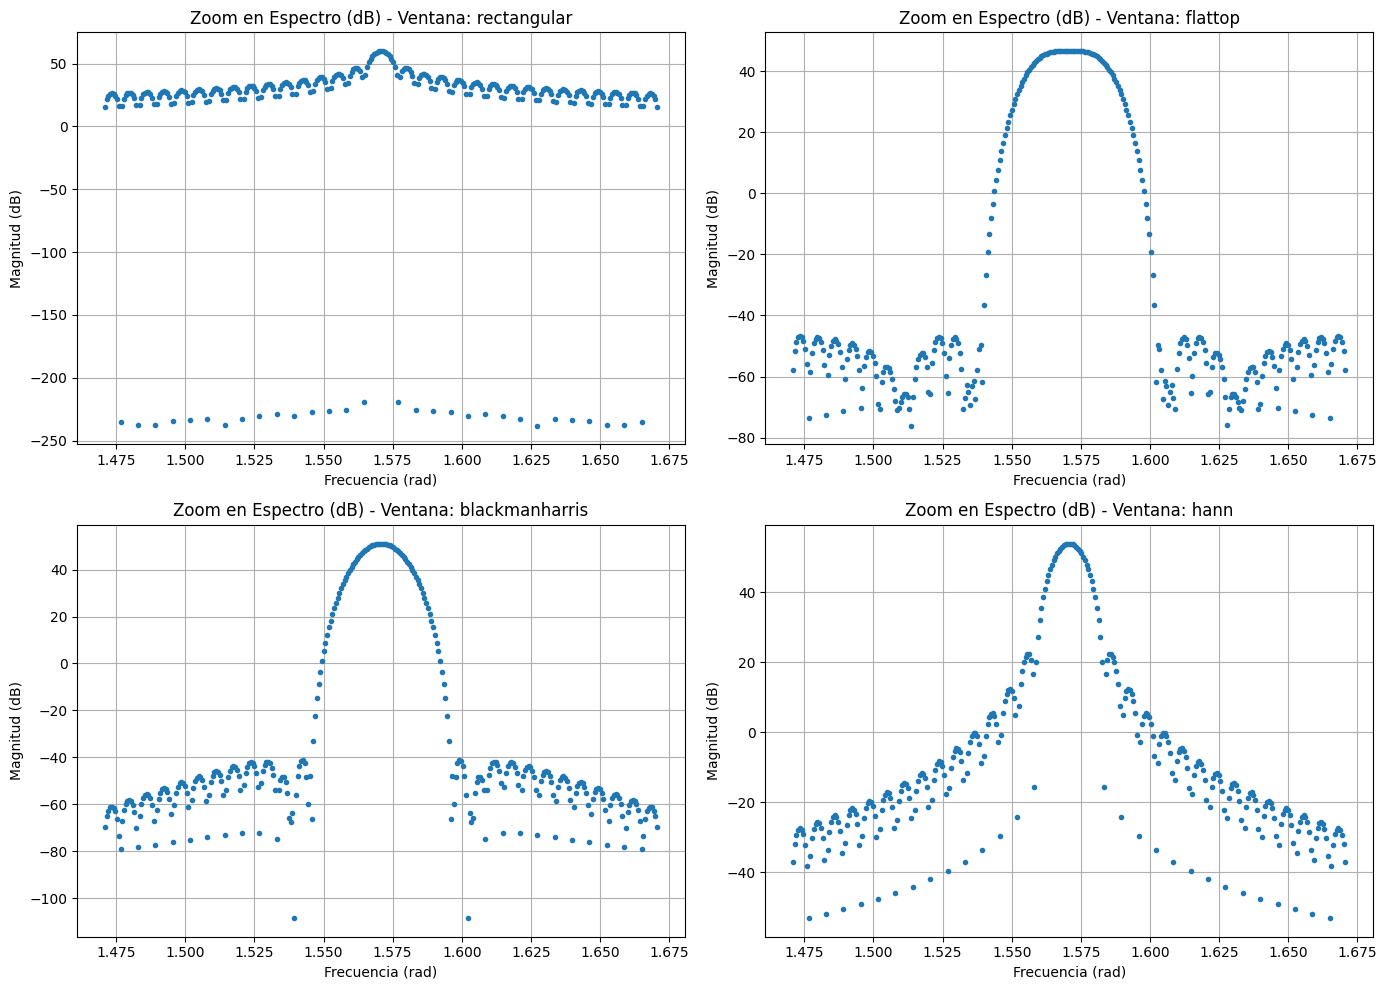

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import scipy.signal.windows as win

# Parámetros generales
N = 1000
N_pad = 10 * N  # Zero-padding

a0 = 2
Omega_0 = np.pi / 2
fr = 0
Omega_1 = Omega_0 + fr * (2 * np.pi / N)

k = np.arange(N)
x = a0 * np.sin(Omega_1 * k)

windows = {
    'rectangular': np.ones(N),
    'flattop': win.flattop(N),
    'blackmanharris': win.blackmanharris(N),
    'hann': win.hann(N)
}

plt.figure(figsize=(14, 10))

for i, (wname, w) in enumerate(windows.items(), 1):
    xw = x * w
    xw_padded = np.concatenate([xw, np.zeros(N_pad - N)])

    X = fft(xw_padded)
    freqs = fftfreq(N_pad, 1) * 2 * np.pi

    X_mag_db = 20 * np.log10(np.abs(X[:N_pad // 2]) + 1e-12)
    freqs = freqs[:N_pad // 2]

    # Zoom: entorno de Omega_1 ± 0.1 rad
    mask = (freqs > Omega_1 - 0.1) & (freqs < Omega_1 + 0.1)

    plt.subplot(2, 2, i)
    plt.plot(freqs[mask], X_mag_db[mask], marker='o', linestyle='None', markersize=3)
    plt.title(f"Zoom en Espectro (dB) - Ventana: {wname}")
    plt.xlabel("Frecuencia (rad)")
    plt.ylabel("Magnitud (dB)")
    plt.grid(True)

plt.tight_layout()
plt.show()


### Concluciones:
<img src="../img/holton_ventanas.png" /> 

Al aplicar una ventana a una señal antes de transformarla con la FFT, se busca reducir el efecto del leakage (fugas espectrales) que ocurre cuando la señal no es perfectamente periódica dentro del marco de observación. A continuación, se describen las caractenisticas mas imporntantes de cada una, es importante saber que como todo en la ingenieria nos encontramos en un problema de sabana corta debido a que si queremos mejorar el ancho de banda tendremos que disminiuir la distancia entre el maximo y el maximo del primer lobulo. Debido a esto hay diferentes tipos de ventanas las cuales nos permiten elegir extremos (como la Rectangular o la Clack Blackman) o situaciones mas intermedias como Hann y Hamming.

### 1. Rectangular:
+ No se coloca ninguna ventana.
+ Ancho de banda de $\Delta \omega=\frac{4\pi}{N}$
+ $-13dB$ entre el maximo y el primer lobulo.
+ Caída de lóbulos: Lenta (-6 dB/oct).

### 2. Hamming:
+ Ancho de banda de $\Delta \omega=\frac{8\pi}{N}$
+ $-43dB$ entre el maximo y el primer lobulo
+ Caída: Lenta (-6 dB/oct).

### 3. Hann:
+ Ancho de banda de $\Delta \omega=\frac{8\pi}{N}$
+ $-32dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).

### 4. Blackman:
+ Ancho de banda de $\Delta \omega=\frac{12\pi}{N}$
+ $-58dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).

### 4. FlatTop:
+ Ancho de banda de $\Delta \omega=\frac{12\pi}{N}$
+ $-93dB$ entre el maximo y el primer lobulo
+ Caída: Rápida (-18 dB/oct).


